# Assignment 1

Author: Celine Tan (U2120113L), Hung Kuo Chen (U2120045A), Rhea Kenneth (U2120878K)

All work was equally distributed among the three members

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.3 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.0
    Uninstalling setuptools-67.6.0:
      Successfully uninstalled setuptools-67.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


## Importing dependencies and define helper functions

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Task 1: Development of an RL agent

In [2]:
env = gym.make("CartPole-v1")

The cart position and pole angle are continuous. In order to implement Q-learning, we need to make the state discrete to be stored in Q table (Ken, 2021) and we define a Discrete function to discretize the state.

In [3]:
def discretize_state(observation, env, buckets=(1, 1, 6, 12)):

  n = env.observation_space

  # Determine the upper and the lower bounds
  upper_bounds = [n.high[0], 0.5, n.high[2], math.radians(50) / 1.]
  lower_bounds = [n.low[0], -0.5, n.low[2], -math.radians(50) / 1.]

  ratios = [(observation[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(observation))]

  state = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(observation))]
  state = [min(buckets[i] - 1, max(0, state[i])) for i in range(len(observation))]

  return tuple(state) 

We define train_agent1 to train our agent with discount factor equals to 0.98 and learning rate equals to 0.1.

(Line 31-32) While for epsilon, the beginning value is 0.5 but it will decay over every episodes at a decay factor if 0.999. The reason we doing so is because as we have trained our model, we have less need for exploration but need more exploitation to exploit Q table. Thus as trials increase, epsilon will be decreasing.


In [4]:
def train_agent1(env, episodes, discount_factor = 0.98, learning_rate = 0.1, epsilon = 0.5):

  q_table = np.zeros((1, 1, 6, 12) + (env.action_space.n,))
  total_reward = []

  for episode in range(1, episodes+1):

    # set initial state
    current_state = discretize_state(env.reset(), env)
    done = False
    cumulative_reward = 0

    while not done:

      # exploration 
      if np.random.uniform(0,1) < epsilon:
        action = env.action_space.sample()

      # exploitation
      else:
            action = np.argmax(q_table[current_state])

      observation, reward, done, info = env.step(action)
      next_state = discretize_state(observation, env)
      
      # update q_table
      if not done:
        max_future_q = np.max(q_table[next_state])
        current_q = q_table[current_state][action]
        new_q = (1-learning_rate)*current_q + learning_rate*(reward + discount_factor*max_future_q)
        q_table[current_state][action] = new_q
        
      current_state = next_state
      cumulative_reward += reward

    # decay epsilon after each episode
    if epsilon >= 0.01:
      epsilon *= 0.9999
    
    total_reward.append(cumulative_reward)

  return q_table, total_reward

We train_agent2 to train another agent with the same discount factor (0.98).

However, we made further improvement by decaying the learning rate and exploration rate of the agent over each episode by using a log function. (Ken, 2021). 

The reason behind why we decayed the learning rate is because when the trials increases, we only need smaller improvement to converge.


In [5]:
def train_agent2(env, episodes, discount_factor = 0.98):

  q_table = np.zeros((1, 1, 6, 12) + (env.action_space.n,))
  total_reward = []

  for episode in range(episodes):

    # set initial state
    current_state = discretize_state(env.reset(), env)
    done = False
    cumulative_reward = 0
    
    # function to decay learning and exploration rate
    learning_rate = epsilon = max(0.1, min(1., 1. - np.log10((episode + 1) / 25.)))

    while not done:

      # exploration 
      if np.random.uniform(0,1) < epsilon:
        action = env.action_space.sample()

      # exploitation
      else:
        action = np.argmax(q_table[current_state])

      observation, reward, done, info = env.step(action)
      next_state = discretize_state(observation, env)
      
      # update q_table
      if not done:
        max_future_q = np.max(q_table[next_state])
        current_q = q_table[current_state][action]
        new_q = (1-learning_rate)*current_q + learning_rate*(reward + discount_factor*max_future_q)
        q_table[current_state][action] = new_q
        
      current_state = next_state
      cumulative_reward += reward
      
    total_reward.append(cumulative_reward)

  return (q_table, total_reward)

The diagram below shows how learning rate and exploration rate decay over 500 episodes under log function.

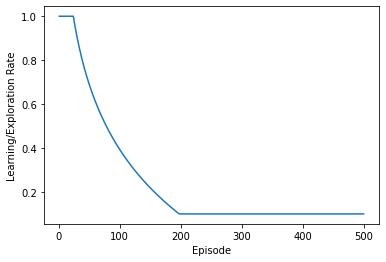

In [26]:
# Generate sample x points 
x = np.linspace(1, 500, 500)
# Get the corresponding rates
y = np.array([max(0.1, min(1., 1. - np.log10((i + 1) / 25.))) for i in x])
plt.plot(x, y)
plt.xlabel("Episode")
plt.ylabel("Learning/Exploration Rate")
plt.show()

We defined trained_agent to return the optimal action from the Q table based on given observation.

In [6]:
def trained_agent(q_table, observation):
  observation = discretize_state(observation, env)
  action = np.argmax(q_table[observation])
  return action

In [7]:
# train train_agent1 and train_agent2
q_table1, total_reward1 = train_agent1(env, 500)
q_table2, total_reward2 = train_agent2(env, 500)

We plotted line graph to compare the cumulative rewards over 500 episodes of train_agent1 and train_agent2.

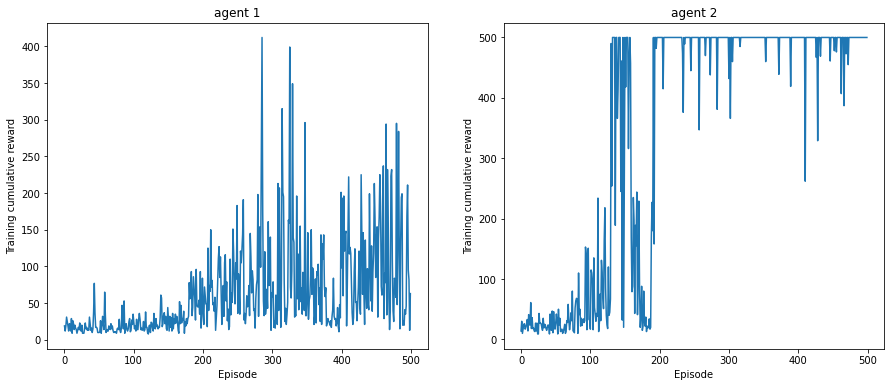

In [34]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)

plt.plot(range(500), total_reward1)
plt.title('agent 1')
plt.xlabel('Episode')
plt.ylabel('Training cumulative reward')

plt.subplot(1,2,2)

plt.plot(range(500), total_reward2)
plt.title('agent 2')
plt.xlabel('Episode')
plt.ylabel('Training cumulative reward')
plt.show()

In [35]:
print("Average cumulative reward for agent 1:", sum(total_reward1)/len(total_reward1))
print("Is my agent good enough?", sum(total_reward1)/len(total_reward1) > 195)
print()

print("Average cumulative reward for agent 2:", sum(total_reward2)/len(total_reward2))
print("Is my agent good enough?", sum(total_reward2)/len(total_reward2) > 195)
print()

Average cumulative reward for agent 1: 62.922
Is my agent good enough? False

Average cumulative reward for agent 2: 345.048
Is my agent good enough? True



We concluded that train_agent2 is better as for the same number of episodes being trained, train_agent2 return a higher average cumulative reward.

We deployed train_agent2 to decide the optimal action for one observation 

In [31]:
observation = env.reset()
action = trained_agent(q_table2, observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.02916379  0.01243111  0.00812537  0.02920238]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

We run another 100 episodes for train_agent 2 to demonstrate the effectiveness of agent 2.

In [13]:
episodes = 100
episode_rewards2 = np.zeros(episodes)

for episode in range(episodes):
  observation = env.reset()
  cumulative_reward = 0
  done = False

  while not done:
      action = trained_agent(q_table2, observation)
      observation, reward, done, info = env.step(action)
      observation = observation
      cumulative_reward += reward

  episode_rewards2[episode] = cumulative_reward

The graph below shows that the cumulative reward for each episode is 500. The reason behind is because as learning rate decays, the cumulative rewards converges to 500.

Text(0.5, 0, 'episode')

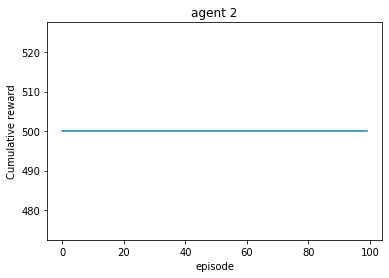

In [33]:
# visualize cumulative rewards for each episode for the agent
plt.plot(episode_rewards2)
plt.title('agent 2')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')

In [32]:
print("The maximum reward for agent 2:", episode_rewards2.max())
print("Average cumulative reward for agent 2:", episode_rewards2.mean())
print("Is my agent good enough?", episode_rewards2.mean() > 195)
print()

The maximum reward for agent 2: 500.0
Average cumulative reward for agent 2: 500.0
Is my agent good enough? True



## Task 3: Render one episode played by the agent

In [17]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = trained_agent(q_table2, observation)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()

## References
Ken. (2021, April 30). Intro to Q-learning in RL. Deepnote. https://deepnote.com/@ken-e7bd/Intro-to-Q-learning-in-RL-e11e39d2-cebf-4552-8920-2db18aab3bd6